## Approach

In selecting an approach for object detection, I opted for the YOLO model due to its robust performance capabilities. An initial evaluation of the general yolov8n.pt model revealed that while it performed well in detecting prevalent objects such as people and cars, it faced challenges in recognizing less common items, notably mushrooms.

To address this, I turned to the Open Images dataset, extracting labeled images specific to mushrooms. While other categories were considered, some were already well-detected by the general model, making additional training redundant. Conversely, some categories had insufficient samples, rendering them unsuitable for effective model training.

Consequently, I focused my efforts on enhancing the model's detection capabilities for the mushroom category, leveraging data from the Open Images dataset to train the YOLO model specifically for this task.

## Import Required Packages and Libraries

In [14]:
import fiftyone.zoo as foz
import fiftyone as fo
from fiftyone import ViewField as F
from ultralytics import YOLO
import os
from PIL import Image
import shutil
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.metrics import precision_score, recall_score



## Data collection and Preprocessing

Most of this part is handeled by fiftyone library.

FiftyOne is a tool for visualizing and exploring datasets, and when it downloads data from the internet, it fetches the required data, stores it in a temporary location, and creates a temporary dataset that users can interact with.


Below code accepts Category as 'Mushroom' as we are training the model for this category only, split as 'train', 'test' and 'validation', label_types as 'detections'(we can pass 'segmentations' here for segmentation tasks), max_samples as 2000.
It fetches 1782 images from training data as we'll analyze later.

In [40]:
typesDataset =["test", "train", "validation"]

for typeDataset in typesDataset:
    # Load the dataset
    dataset = foz.load_zoo_dataset(
        "open-images-v7",
        split=typeDataset,
        label_types=["detections"],
        classes=["Mushroom"],
        max_samples=2000,
    )

Only found 226 (<2000) samples matching your requirements
Necessary images already downloaded
Existing download of split 'test' is sufficient
Loading existing dataset 'open-images-v7-test-2000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Only found 1782 (<2000) samples matching your requirements
Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading 'open-images-v7' split 'train'
 100% |███████████████| 1782/1782 [10.3s elapsed, 0s remaining, 197.0 samples/s]      
Dataset 'open-images-v7-train-2000' created
Only found 64 (<2000) samples matching your requirements
Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading 'open-images-v7' split 'validation'
 100% |███████████████████| 64/64 [282.1ms elapsed, 0s remaining, 226.9 samples/s]      
Dataset 'open-images-v7-validation-2000' created


In [43]:
# List all datasets
datasets = fo.list_datasets()

# Print the datasets
for dataset_name in datasets:
    print(dataset_name)

open-images-v7-test-2000
open-images-v7-train-2000
open-images-v7-validation-2000


In [46]:
# List of datasets
dataset_names = [
    "open-images-v7-test-2000",
    "open-images-v7-train-2000",
    "open-images-v7-validation-2000"
]

# Iteratively load and print the number of samples for each dataset
for dataset_name in dataset_names:
    dataset = fo.load_dataset(dataset_name)
    print(f"Number of samples in {dataset_name}: {len(dataset)}")

Number of samples in open-images-v7-test-2000: 312
Number of samples in open-images-v7-train-2000: 1782
Number of samples in open-images-v7-validation-2000: 64


Starting the fiftyone interactive browser session and analyzing training dataset

In [45]:
dataset = fo.load_dataset('open-images-v7-train-2000')

# Create a session
session = fo.launch_app(dataset)

# Use the session...

# When done, close the session
session.close()

On analyzing the data, Images with bounding bozes looks fine but It's obsereved that labels are categorized into multiple categories and for training a good mushroom detector, we'll need only samples that are labeled as 'Mushroom', so filtering out those samples in below code.

In [47]:
# List of original datasets and their corresponding filtered dataset names
datasets_info = {
    "open-images-v7-test-2000": "FilteredDatasetTest",
    "open-images-v7-train-2000": "FilteredDatasetTrain",
    "open-images-v7-validation-2000": "FilteredDatasetValidation"
}

# Iteratively process and create new datasets for each original dataset
for orig_dataset_name, filtered_dataset_name in datasets_info.items():
    
    # Load the original dataset
    dataset = fo.load_dataset(orig_dataset_name)
    
    # Define a view that only includes samples whose `detections` field only contains `Mushroom` labels
    only_mushrooms_view = dataset.match(
        {"$expr": {
            "$eq": [{"$setDifference": ["$ground_truth.detections.label", ["Mushroom"]]}, []]
        }}
    )
    
    # Delete the filtered dataset if it exists
    if fo.dataset_exists(filtered_dataset_name):
        fo.delete_dataset(filtered_dataset_name)
    
    # Create a new dataset with the appropriate name
    filtered_dataset = fo.Dataset(name=filtered_dataset_name)
    
    # Copy samples from view to new dataset
    for sample in only_mushrooms_view:
        filtered_dataset.add_sample(sample)

# Delete the original datasets
for orig_dataset_name in datasets_info.keys():
    if fo.dataset_exists(orig_dataset_name):
        fo.delete_dataset(orig_dataset_name)


Filtered original datasets for onlu 'Mushroom' label as FilteredDatasetTest, FilteredDatasetTrain and FilteredDatasetValidation.

Also, deleted the original datasets from memory

In [49]:
# List all datasets
datasets = fo.list_datasets()

# Print the datasets
for dataset_name in datasets:
    print(dataset_name)

FilteredDatasetTest
FilteredDatasetTrain
FilteredDatasetValidation


## Data Reformat for YOLO model

Loading three datasets, then reformating and exporting their images and bounding box labels into YOLO-compatible directories for training, validation, and testing.

In [21]:
# Load the dataset
dataset_train = fo.load_dataset("FilteredDatasetTrain")
dataset_validation = fo.load_dataset("FilteredDatasetValidation")
dataset_test = fo.load_dataset("FilteredDatasetTest")

# Get the class names in the dataset
class_names = dataset_train.distinct("ground_truth.detections.label")
class_names.sort()
class_dict = {name: idx for idx, name in enumerate(class_names)}

# Output directories for YOLO formatted labels and images
output_dir_imgs_train = "./data/images/train/"
output_dir_lbls_train = "./data/labels/train/"
output_dir_imgs_val = "./data/images/val/"
output_dir_lbls_val = "./data/labels/val/"
output_dir_imgs_test = "./data/images/test/"
output_dir_lbls_test = "./data/labels/test/"

# Ensure directories exist
os.makedirs(output_dir_imgs_train, exist_ok=True)
os.makedirs(output_dir_lbls_train, exist_ok=True)
os.makedirs(output_dir_imgs_val, exist_ok=True)
os.makedirs(output_dir_lbls_val, exist_ok=True)
os.makedirs(output_dir_imgs_test, exist_ok=True)
os.makedirs(output_dir_lbls_test, exist_ok=True)

datasets = [
    (dataset_train, output_dir_imgs_train, output_dir_lbls_train),
    (dataset_validation, output_dir_imgs_val, output_dir_lbls_val),
    (dataset_test, output_dir_imgs_test, output_dir_lbls_test),
]

for dataset, output_dir_imgs, output_dir_lbls in datasets:
    for sample in dataset:
        # Create a file for each image
        filename = os.path.splitext(os.path.basename(sample.filepath))[0]
        with open(os.path.join(output_dir_lbls, filename + ".txt"), "w") as f:
            # Convert each detection in the sample
            for detection in sample.ground_truth.detections:
                # Convert the bounding box format
                # From [xmin, ymin, width, height] (in relative coordinates)
                # To [class, xcenter, ycenter, width, height] (in relative coordinates)
                bbox = detection.bounding_box
                xcenter = bbox[0] + bbox[2] / 2
                ycenter = bbox[1] + bbox[3] / 2
                class_idx = class_dict[detection.label]

                # Write the bounding box to the file
                f.write(f"{class_idx} {xcenter} {ycenter} {bbox[2]} {bbox[3]}\n")
    
        # Copy the corresponding image file to the output directory
        shutil.copy(sample.filepath, os.path.join(output_dir_imgs, filename + ".jpg"))


## Data Augmetation

The image augmentation process was successfully implemented; however, due to time constraints, I was unable to extend the augmentation logic to the labels and have opted to bypass that component for now.

In [16]:
# # Data Augmentation

# # Define your two different augmentations
# transform_1 = A.Compose([
#     A.HorizontalFlip(p=1),  # Always apply horizontal flip
#     A.RandomBrightnessContrast(p=0.5)
# ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# transform_2 = A.Compose([
#     A.VerticalFlip(p=1),  # Always apply vertical flip
#     A.RandomGamma(p=0.5)
# ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


# output_dirs_imgs = [output_dir_imgs_train, output_dir_imgs_val, output_dir_imgs_test]
# output_dirs_lbls = [output_dir_lbls_train, output_dir_lbls_val, output_dir_lbls_test]

# def convert_to_albumentations_format(bbox, img_width, img_height):
#     class_idx, x_center, y_center, width, height = bbox
#     x_min = x_center - width / 2
#     y_min = y_center - height / 2
#     x_max = x_center + width / 2
#     y_max = y_center + height / 2
    
#     x_min /= img_width
#     y_min /= img_height
#     x_max /= img_width
#     y_max /= img_height
    
#     return [x_min, y_min, x_max, y_max]

# def convert_from_albumentations_format(bbox, img_width, img_height):
#     x_min, y_min, x_max, y_max = bbox
#     x_min *= img_width
#     y_min *= img_height
#     x_max *= img_width
#     y_max *= img_height
    
#     x_center = (x_min + x_max) / 2
#     y_center = (y_min + y_max) / 2
#     width = x_max - x_min
#     height = y_max - y_min
    
#     return [x_center, y_center, width, height]

# for output_dir_imgs, output_dir_lbls in zip(output_dirs_imgs, output_dirs_lbls):
#     image_names = [img for img in os.listdir(output_dir_imgs) if not img.startswith('.') and not img.startswith('aug')]

#     for image_name in image_names:
#         image_path = os.path.join(output_dir_imgs, image_name)
#         image = cv2.imread(image_path)
#         img_height, img_width = image.shape[:2]

#         label_path = os.path.join(output_dir_lbls, os.path.splitext(image_name)[0] + ".txt")
#         if os.path.exists(label_path):
#             with open(label_path, "r") as file:
#                 labels = file.readlines()
#         else:
#             continue

#         bboxes = []
#         class_labels = []
#         for label in labels:
#             data = list(map(float, label.strip().split()))
#             bbox_albumentations = convert_to_albumentations_format(data, img_width, img_height)
#             bboxes.append(bbox_albumentations)
#             class_labels.append(int(data[0]))

#         augmented_1 = transform_1(image=image, bboxes=bboxes, class_labels=class_labels)
#         cv2.imwrite(os.path.join(output_dir_imgs, 'aug1_' + image_name), augmented_1['image'])
#         with open(os.path.join(output_dir_lbls, 'aug1_' + os.path.splitext(image_name)[0] + ".txt"), "w") as file:
#             for bbox, class_label in zip(augmented_1['bboxes'], augmented_1['class_labels']):
#                 bbox_original = convert_from_albumentations_format(bbox, img_width, img_height)
#                 file.write(f"{class_label} {bbox_original[0]} {bbox_original[1]} {bbox_original[2]} {bbox_original[3]}\n")

#         augmented_2 = transform_2(image=image, bboxes=bboxes, class_labels=class_labels)
#         cv2.imwrite(os.path.join(output_dir_imgs, 'aug2_' + image_name), augmented_2['image'])
#         with open(os.path.join(output_dir_lbls, 'aug2_' + os.path.splitext(image_name)[0] + ".txt"), "w") as file:
#             for bbox, class_label in zip(augmented_2['bboxes'], augmented_2['class_labels']):
#                 bbox_original = convert_from_albumentations_format(bbox, img_width, img_height)
#                 file.write(f"{class_label} {bbox_original[0]} {bbox_original[1]} {bbox_original[2]} {bbox_original[3]}\n")


In [15]:
# # Deleting Augmented Images


# output_dir_imgs_train = "./data/images/train/"
# output_dir_lbls_train = "./data/labels/train/"
# output_dir_imgs_val = "./data/images/val/"
# output_dir_lbls_val = "./data/labels/val/"
# output_dir_imgs_test = "./data/images/test/"
# output_dir_lbls_test = "./data/labels/test/"

# # Directories for augmented images and labels
# output_dirs_imgs = [output_dir_imgs_train, output_dir_imgs_val, output_dir_imgs_test]
# output_dirs_lbls = [output_dir_lbls_train, output_dir_lbls_val, output_dir_lbls_test]

# for output_dir_imgs, output_dir_lbls in zip(output_dirs_imgs, output_dirs_lbls):
#     image_names = os.listdir(output_dir_imgs)
#     label_names = os.listdir(output_dir_lbls)

#     for image_name in image_names:
#         # If image file name starts with 'aug1_' or 'aug2_', delete it
#         if image_name.startswith(('aug1_', 'aug2_')):
#             os.remove(os.path.join(output_dir_imgs, image_name))

#     for label_name in label_names:
#         # If label file name starts with 'aug1_' or 'aug2_', delete it
#         if label_name.startswith(('aug1_', 'aug2_')):
#             os.remove(os.path.join(output_dir_lbls, label_name))


## Image and Labels verification

Reads and displays the first few images from a specified directory, overlaying bounding boxes from labels to corresponding images

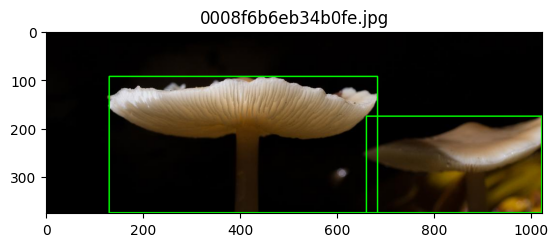

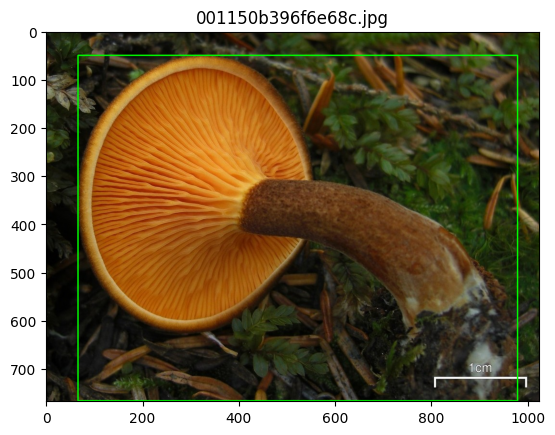

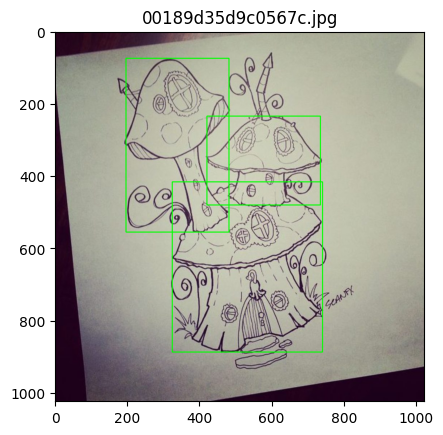

In [18]:

# Path to images and labels
image_dir = "data/images/train/"
label_dir = "data/labels/train/"

# Get all image files from the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Select 3 sample images
selected_image_files = image_files[:3]

# For each selected image file
for image_file in selected_image_files:
    # Read image
    img = cv2.imread(os.path.join(image_dir, image_file))

    if img is None:
        print(f"Failed to load image {image_file}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color space for matplotlib
    img_height, img_width = img.shape[:2]

    # Corresponding label file
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(label_dir, label_file)

    # If label file exists
    if os.path.exists(label_path):
        with open(label_path, "r") as file:
            lines = file.readlines()

        # For each line in label file (each object)
        for line in lines:
            class_idx, x, y, w, h = map(float, line.split())
            x *= img_width
            w *= img_width
            y *= img_height
            h *= img_height

            # Draw bounding box
            start_point = (int(x - w/2), int(y - h/2))  # top left corner
            end_point = (int(x + w/2), int(y + h/2))  # bottom right corner
            color = (0, 255, 0)  # green color in RGB
            thickness = 2
            img = cv2.rectangle(img, start_point, end_point, color, thickness)

        # Display image with bounding boxes
        plt.imshow(img)
        plt.title(image_file)
        plt.show()
    else:
        print(f"No label file found for {image_file}")


## Model training

Due to hardware limitations, I had to perform this step on google colaboratory.
Attching the colab code for reference:
access the notebook from here: https://colab.research.google.com/drive/1irAhZMcWO-DzhO8T24XVhOcma4lPljQp#scrollTo=Pg5yeRiFmVYu

Uploaded the data folder and config.yaml file from main directory to google drive.

In [ ]:
# !pip install ultralytics

# from ultralytics import YOLO
# from google.colab import drive


# config_path = "/content/drive/MyDrive/Colab Notebooks/config.yaml"


# drive.mount('/content/drive'

# model = YOLO()
# 
results = model.train(data= config_path, epochs= 105))

Model is saved in the runs folder once training is over as 'best.pt'

## Results

Comparing the predictions from trained model(best105.pt) against general yolo model(yolov8n.pt) on test images dataset("./data/images/test/")


0: 640x640 1 Mushroom, 1: 640x640 1 Mushroom, 2: 640x640 1 Mushroom, 3: 640x640 1 Mushroom, 4: 640x640 7 Mushrooms, 5: 640x640 1 Mushroom, 6: 640x640 1 Mushroom, 7: 640x640 1 Mushroom, 8: 640x640 1 Mushroom, 9: 640x640 2 Mushrooms, 1645.4ms
Speed: 6.1ms preprocess, 164.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 1: 640x640 1 bird, 1 teddy bear, 2: 640x640 1 fire hydrant, 3: 640x640 2 teddy bears, 4: 640x640 3 carrots, 5: 640x640 1 bowl, 6: 640x640 1 cat, 7: 640x640 1 teddy bear, 8: 640x640 1 cake, 9: 640x640 (no detections), 1633.0ms
Speed: 5.3ms preprocess, 163.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


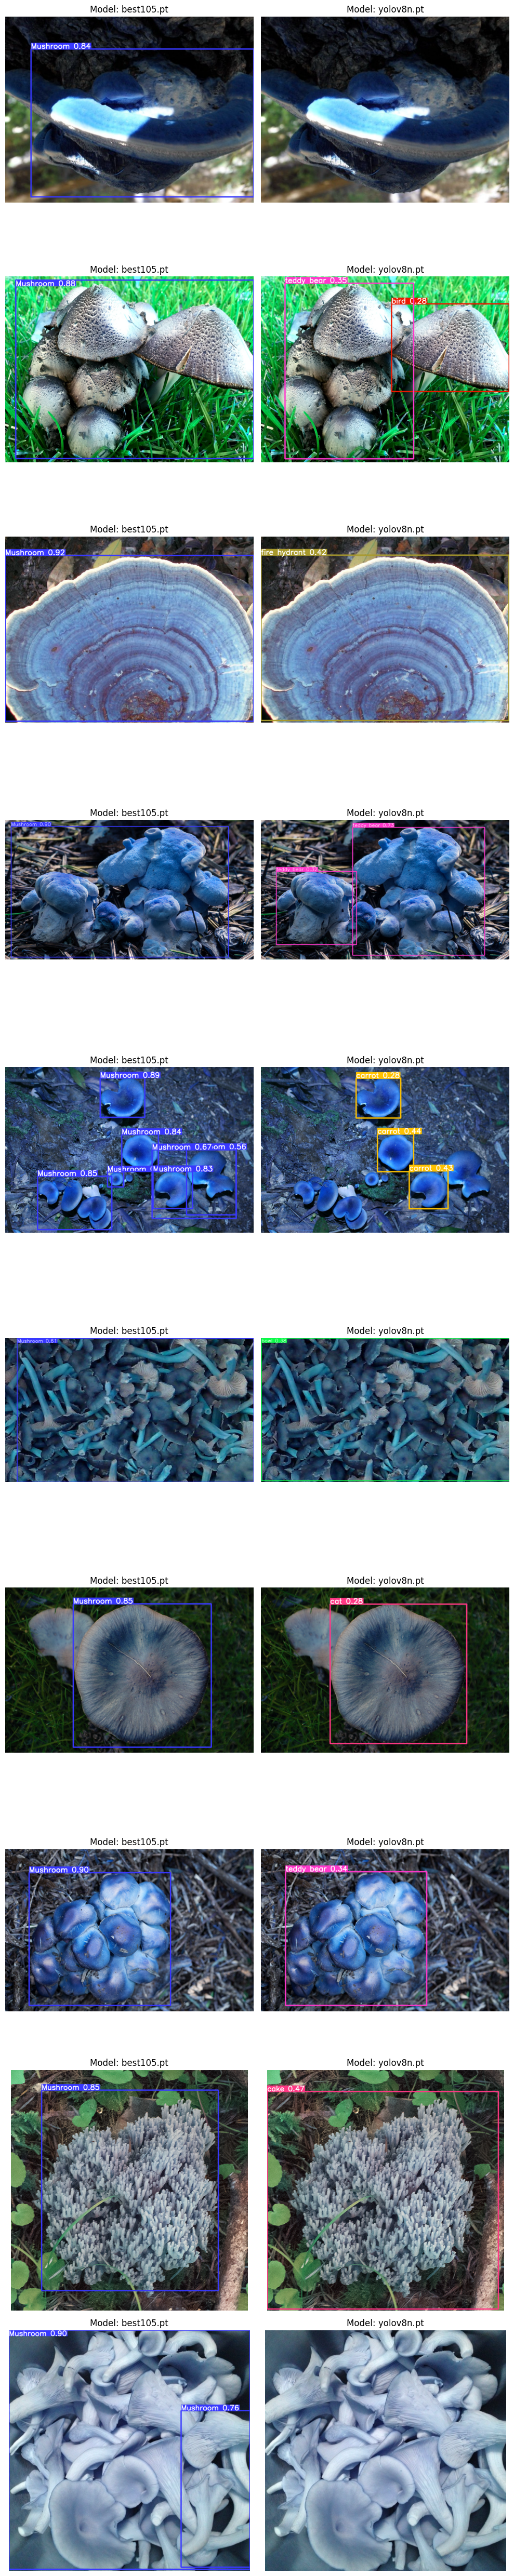

In [32]:
model1 = YOLO('best105.pt')
model2 = YOLO('yolov8n.pt')

# Define the directory containing the images
output_dir_imgs_test = "./data/images/test/"

# Get a list of sample images (assuming the directory only contains image files)
sample_images = [f"{output_dir_imgs_test}{img}" for img in os.listdir(output_dir_imgs_test)[10:20]]

# Run batched inference on the sample images for both models
results1 = model1(sample_images)
results2 = model2(sample_images)

# Display the results side by side in 2 columns
fig, axes = plt.subplots(len(sample_images), 2, figsize=(10, 5 * len(sample_images)))

for i in range(len(sample_images)):
    # Plot results on the original image for model1
    img1 = results1[i].plot()
    axes[i, 0].imshow(img1)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Model: best105.pt')

    # Plot results on the original image for model2
    img2 = results2[i].plot()
    axes[i, 1].imshow(img2)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Model: yolov8n.pt')

plt.tight_layout()
plt.show()

Trained model is performing better at most test data instances

## Strengths and Areas of Improvement

Even with limited sample training data, the model seems to perform good on test dataset.
However, I tested the model on images having similar looking objects like a 'flower' and it detects some of them as mushroom as well

## Performamce Metrics

While working on the model evaluation, I encountered challenges with the implementation of evaluation metrics. I understand the importance of this task and am actively seeking solutions.

In [29]:

# # Function to compute Intersection over Union
# def compute_iou(box1, box2):
#     box1 = [box1[0]-box1[2]/2, box1[1]-box1[3]/2, box1[0]+box1[2]/2, box1[1]+box1[3]/2]
#     box2 = [box2[0]-box2[2]/2, box2[1]-box2[3]/2, box2[0]+box2[2]/2, box2[1]+box2[3]/2]
    
#     x1 = max(box1[0], box2[0])
#     y1 = max(box1[1], box2[1])
#     x2 = min(box1[2], box2[2])
#     y2 = min(box1[3], box2[3])
    
#     inter_area = max(0, x2 - x1) * max(0, y2 - y1)
#     box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
#     box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
#     iou = inter_area / (box1_area + box2_area - inter_area)
#     return iou

# # Load model
# model = YOLO('best.pt')

# # Directories
# output_dir_imgs_test = "./data/images/test/"
# output_dir_lbls_test = "./data/labels/test/"

# # Load the test images and labels
# test_images = [os.path.join(output_dir_imgs_test, img) for img in os.listdir(output_dir_imgs_test) if img.endswith(('.jpg', '.png'))]

# # Run inference on the test images
# results = model(test_images)

# # Extract predictions from the results
# predicted_labels = [result.boxes for result in results]

# # Load ground truth labels
# ground_truth_labels = []
# for img_path in test_images:
#     lbl_path = os.path.join(output_dir_lbls_test, os.path.basename(img_path).replace('.jpg', '.txt').replace('.png', '.txt'))
#     with open(lbl_path, 'r') as f:
#         lines = f.readlines()
#         ground_truth_labels.append([list(map(float, line.strip().split())) for line in lines])

# # Evaluation
# true_positives = 0
# false_positives = 0
# false_negatives = 0
# iou_threshold = 0.5

# for i, gt_boxes in enumerate(ground_truth_labels):
#     pred_boxes = predicted_labels[i].data.tolist()  # Convert tensor to list using .data attribute
#     if not pred_boxes:  # Check if pred_boxes is empty
#         false_negatives += len(gt_boxes)
#         continue  # Skip to the next iteration if no detections
#     for gt_box in gt_boxes:
#         max_iou = 0
#         for pred_box in pred_boxes:
#             iou = compute_iou(gt_box[1:], pred_box[1:])
#             max_iou = max(max_iou, iou)
#         if max_iou >= iou_threshold:
#             true_positives += 1
#         else:
#             false_negatives += 1
#     for pred_box in pred_boxes:
#         max_iou = 0
#         for gt_box in gt_boxes:
#             iou = compute_iou(gt_box[1:], pred_box[1:])
#             max_iou = max(max_iou, iou)
#         if max_iou < iou_threshold:
#             false_positives += 1

# precision = true_positives / (true_positives + false_positives)
# recall = true_positives / (true_positives + false_negatives)

# print("Precision:", precision)
# print("Recall:", recall)
